# Quantum Galton Board algorithm

Based on the patterns we observed in the first $4$ levels of the Quantum Galton board, we develp a general algorithm that works for an arbitrary number of levels, $n$. 

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import HGate, RYGate, RXGate, XGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest, norm, expon, stats
from scipy.optimize import curve_fit

%matplotlib inline

In [ ]:
def _pair_sequence_shift_third(r: int, centre: int, right_edge: int) -> list[tuple[int, int]]:
    """Generate pairs of qubits for controlled swaps and CNOT operation in the Galton box.

    Args:
        r (int): Current row index
        centre (int): Centre qubit index
        right_edge (int): set to 2n + 1 for Galton box with n rows
    
    Returns:
        list[tuple[int, int]]: List of pairs of qubit indices for controlled swaps
    """
    pairs = []
    first, second = (centre - r, centre - r + 1), (centre - r + 1, centre - r + 2)
    pairs.extend([first, second])

    if r == 1:  
        return pairs

    gap = 2 * r - 3
    third = (second[1] + gap, second[1] + gap + 1)
    if third[1] <= right_edge:
        pairs.append(third)

    cur = third[0] - 1
    while len(pairs) < 2 * r and cur >= first[0]:
        pair = (cur, cur + 1)
        if pair not in pairs:
            pairs.append(pair)
        cur -= 1
    return pairs

def galton_box_shifted(n: int, coin_gate, *, draw=False) -> QuantumCircuit:
    """
    Quantum Galton Box with customizable coin operations
    
    Args:
        n (int): Number of rows/levels in the Galton box
        coin_gate: Quantum gate or function that returns a gate.
                   If function, should take row index (r) as input.
        draw (bool): Whether to draw the circuit
    
    Returns:
        QuantumCircuit: Configured Galton box circuit
    """
    total_q = 2 * n + 2
    data_q = n + 1
    centre = n + 1
    right = 2*n + 1
    anc = 0

    q = QuantumRegister(total_q, 'q')
    c = ClassicalRegister(data_q, 'c')
    qc = QuantumCircuit(q, c)
    
    # Initialize ball at center
    qc.x(centre)

    # Process rows 1 to n-1 with custom coin gate
    for r in range(1, n):
        qc.reset(anc)
        
        # Apply custom coin operation
        if callable(coin_gate):
            # If coin_gate is a function, call it with current row index
            gate = coin_gate(r)
        else:
            # Use the gate directly
            gate = coin_gate
            
        qc.append(gate, [anc])

        # Get all swap pairs for current row
        pairs = _pair_sequence_shift_third(r, centre, right)

        # Apply controlled-swap operations
        for i, (a, b) in enumerate(pairs):
            qc.cswap(anc, a, b)
            
            # Apply CX to next control
            if i < len(pairs) - 1:
                next_a, _ = pairs[i + 1]
                cx_control = b if next_a > a else a
                qc.cx(cx_control, anc)

    # Process final row (n) with custom ancilla gate
    qc.reset(anc)
    
    # Apply same coin selection logic for final row
    if callable(coin_gate):
        gate = coin_gate(n)  # Use row index n for final row
    else:
        gate = coin_gate
    qc.append(gate, [anc])

    # Final swap sequence
    i = 0
    while i <= 2*n -2:
        qc.cswap(anc, i + 1, i + 2)
        qc.cx(i + 2, anc)
        qc.cswap(anc, i + 2, i + 3)
        if i + 4 < 2*n +1:
            qc.cx(i + 3, anc)
        i += 2
        
    if draw:
        qc.draw('mpl', style='clifford', fold=True)
        plt.show()

    # Measure odd data qubits, as only they are relevant for the final distribution
    for i in range(0, data_q):
        qc.measure(q[2*i+1], c[i])

    return qc


# Generalizing post processing to obtain a smooth normal distribution

def post_process_histogram(memory_bitstrings, block_size):
    
    # one hot encoding of the output bitstrings
    unique_even = sorted(set(memory_bitstrings))
    bitstring_to_int = {b: i for i, b in enumerate(unique_even)}

    # one hot encoding to integer labels
    one_hot_values = [bitstring_to_int[b] for b in memory_bitstrings]

    max_value = max(one_hot_values)
    bin_size= (block_size * max_value) + 1  # Adjust bin size based on block size and max value

    # split into blocks of 8, compute sum per block (8 is the paper's choice) and note the frequency of each sum
    num_blocks = len(one_hot_values) // block_size
    trimmed_values = one_hot_values[:num_blocks * block_size]
    reshaped = np.array(trimmed_values).reshape((num_blocks, block_size))
    block_sums = reshaped.sum(axis=1)

    return memory_bitstrings, block_sums, bin_size

### Testing for a $6-$ level Quantum Galton Board

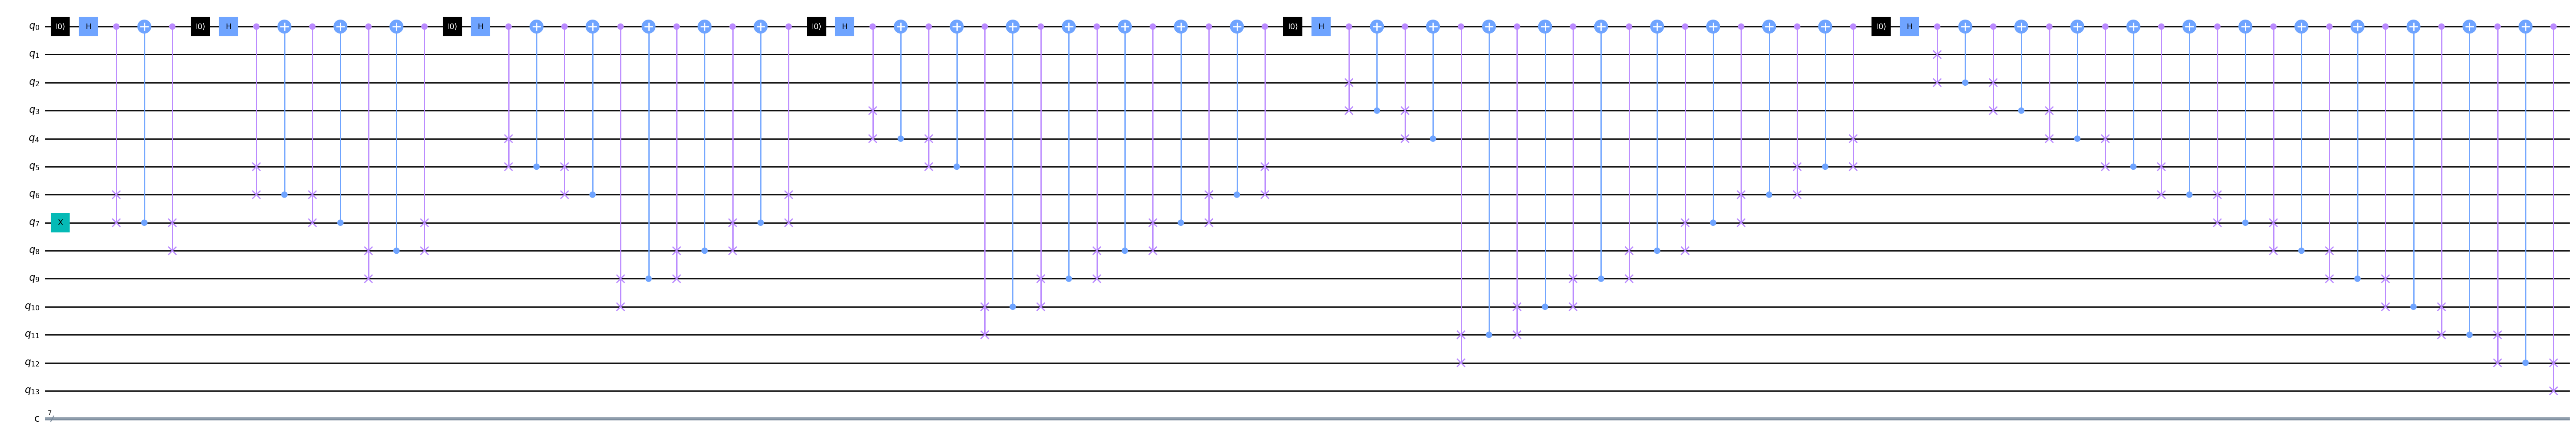

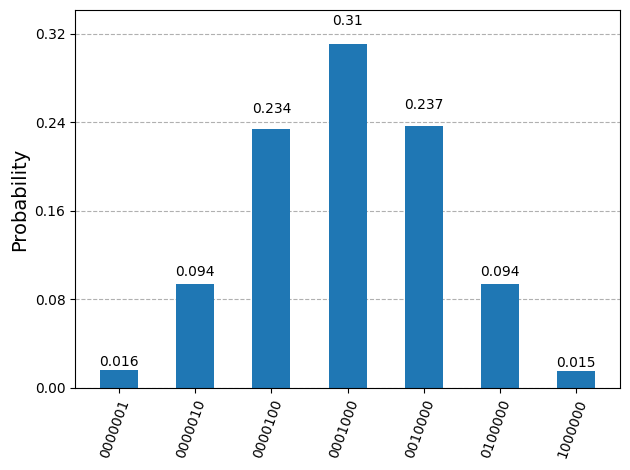

In [3]:
qc = galton_box_shifted(6, HGate(), draw=True)
backend = AerSimulator()

compiled = transpile(qc, backend)

job = backend.run(compiled, shots=100000)
counts = job.result().get_counts()
total_shots = sum(counts.values())
probabilities = {state: count/total_shots for state, count in counts.items()}

plot_histogram(probabilities)
plt.ylabel('Probability')
plt.show()

### Post processing and fitting to a smooth normal distribution

Block Size 5: Best-fit Normal Distribution: mean = 14.99, std = 2.74
Block Size 10: Best-fit Normal Distribution: mean = 29.98, std = 3.87
Block Size 15: Best-fit Normal Distribution: mean = 44.97, std = 4.75
Block Size 20: Best-fit Normal Distribution: mean = 59.96, std = 5.51


Text(0.5, 0.98, 'Histograms with Best-Fit Normal Distributions for Various Block Sizes')

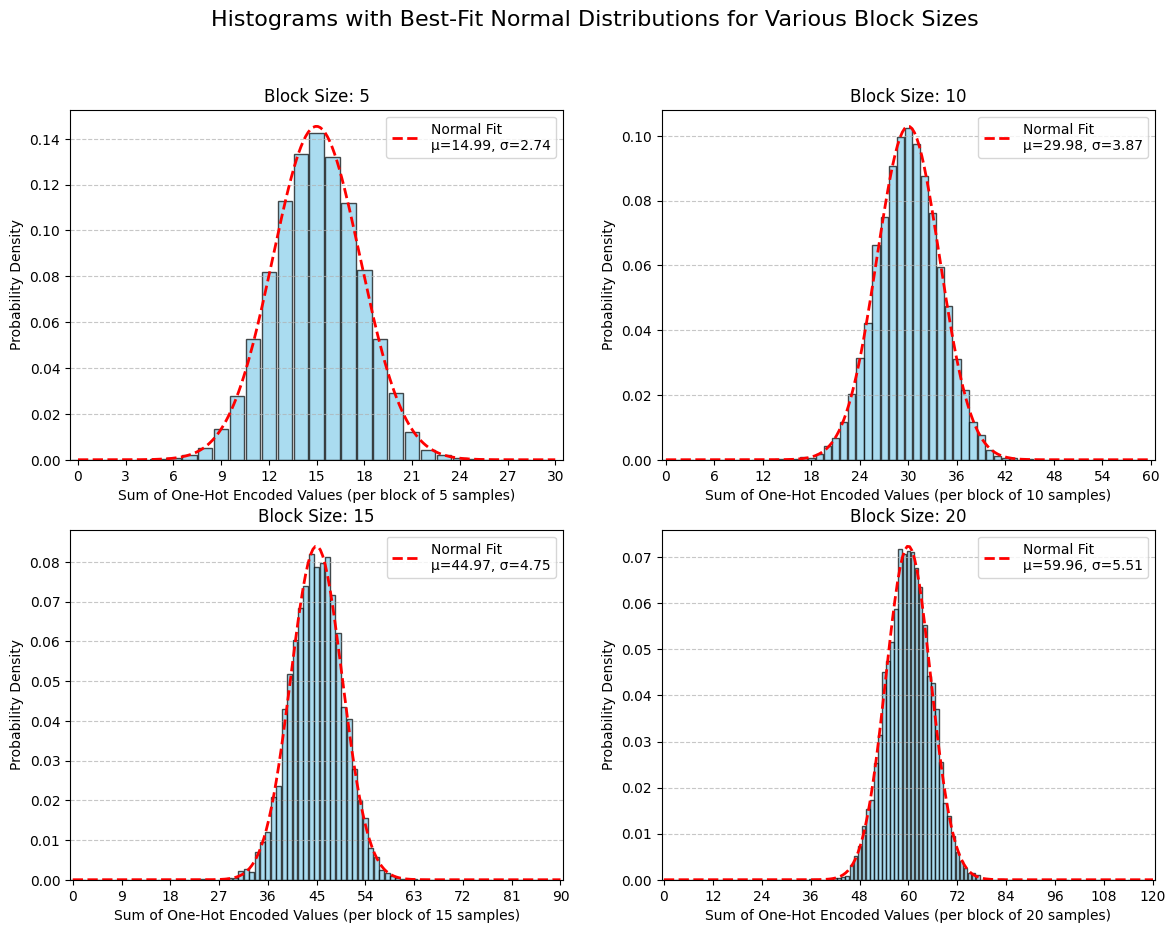

In [ ]:
job = backend.run(compiled, shots=100000, memory=True)
memory_counts = job.result().get_memory()  # to get the list of bitstrings in order of experiments/shots

block_size_list = [5,10,15,20]  # different block sizes for summation

fig_outer, axs_outer = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs_outer_flat = axs_outer.flatten()

for i in range(len(block_size_list)):
    even_bitstrings, block_sums, bin_size = post_process_histogram(memory_counts, block_size_list[i])
    
    # Fit normal distribution
    mu, std = norm.fit(block_sums)   
    print(f"Block Size {block_size_list[i]}: Best-fit Normal Distribution: mean = {mu:.2f}, std = {std:.2f}")
    
    ax = axs_outer_flat[i]  

    # Create histogram with density=True to get probability density
    count, bins, _ = ax.hist(block_sums, bins=range(0, bin_size), align='left', 
                              rwidth=0.9, color='skyblue', edgecolor='black', 
                              density=True, alpha=0.7)
    
    xmin_pdf, xmax_pdf = 0, bin_size - 1 # Adjusted to cover full possible range of sums
    x_pdf = np.linspace(xmin_pdf, xmax_pdf, 200)
    p = norm.pdf(x_pdf, mu, std)
    ax.plot(x_pdf, p, 'r--', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
    ax.legend(loc='upper right')

    ax.set_xlabel(f"Sum of One-Hot Encoded Values (per block of {block_size_list[i]} samples)")
    ax.set_ylabel("Probability Density")
    
    tick_interval = max(1, bin_size // 10) 
    ax.set_xticks(np.arange(0, bin_size, tick_interval))
    ax.set_xlim(-0.5, bin_size - 0.5) 

    ax.set_title(f"Block Size: {block_size_list[i]}") 
    ax.grid(axis='y', linestyle='--', alpha=0.7)


fig_outer.suptitle("Histograms with Best-Fit Normal Distributions for Various Block Sizes", fontsize=16)



#### Therefore, by adjusting the block size parameter, normal distributions with varying means and standard deviations can be obtained.

____


## Complexity Analysis

Qubit count $= 2n+2$. We plot the total gates required and check if it scales efficiently as claimed in the paper, that is $O(n^2)$.

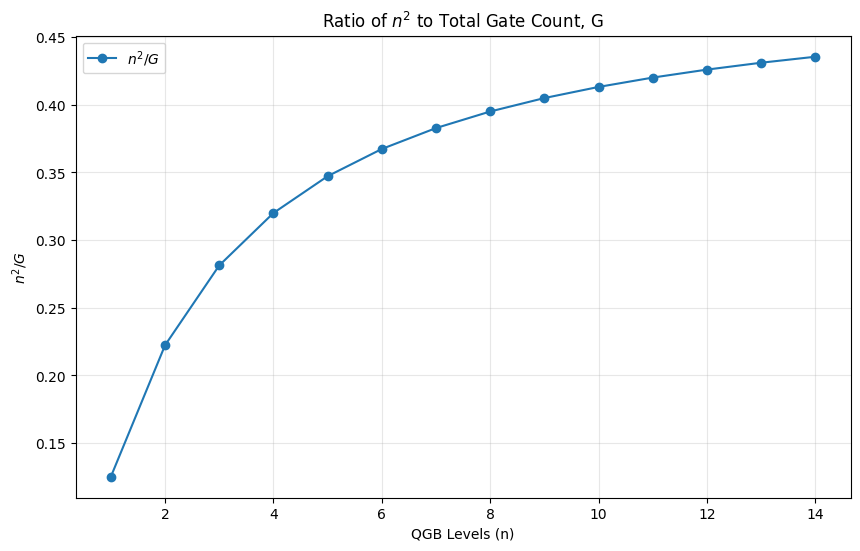

In [16]:
N = []
total_gates = []
for n in range(1, 15):
    qc = galton_box_shifted(n, HGate(), draw=False)
    backend = AerSimulator()
    compiled = transpile(qc, backend, optimization_level=3)
    total_gate = sum(compiled.count_ops().values())
    N.append(n)
    total_gates.append(total_gate)

N_array = np.array(N)
total_gates_array = np.array(total_gates)

# Calculate the ratio n^2 / Total Gate Count
ratio_n2_gates = (N_array ** 2) / total_gates_array

# Create and display the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('QGB Levels (n)')
ax.set_ylabel(r'$n^2 / G$')
ax.plot(N, ratio_n2_gates, 'o-', label=r'$n^2 / G$')
ax.set_title(r'Ratio of $n^2$ to Total Gate Count, G')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()



##### The empirical analysis demonstrates that as $n$ increases, the ratio $n^2/G$ converges to a constant value, confirming that the total gate count $G$ for the generalized Galton board scales quadratically with the number of levels, i.e., $G \in O(n^2)$.

##### **Infact as shown below, G is also a polynomial function of $log_2(N)$ which suggests much better scaling of the generalized transpiled circuit than $O(n^2)$**

Polynomial fits in log₂(n):
Circuit Depth ≈ 7.21(log₂(n))⁴ + -35.75(log₂(n))³ + 70.15(log₂(n))² + -34.85(log₂(n)) + 6.26
Circuit Depth R² = 0.9999

Total Gates ≈ 7.25(log₂(n))⁴ + -35.84(log₂(n))³ + 70.65(log₂(n))² + -34.30(log₂(n)) + 8.26
Total Gates R² = 0.9999


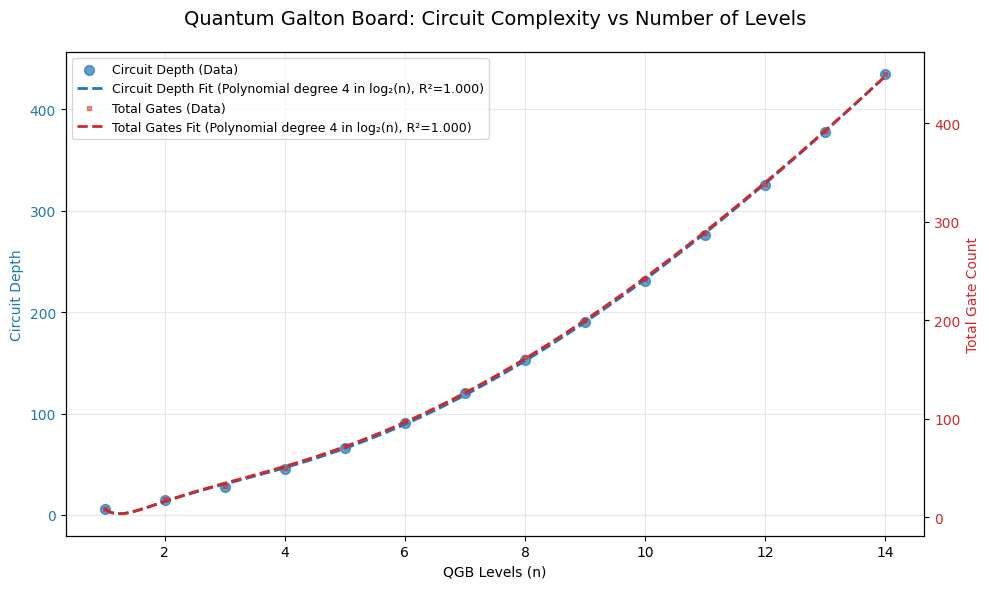

In [19]:
N = []
circuit_depths = []
total_gates = []
for n in range(1, 15):
    qc = galton_box_shifted(n, HGate(), draw=False)
    backend = AerSimulator()
    compiled = transpile(qc, backend, optimization_level=3)
    circuit_depth = compiled.depth()
    total_gate = sum(compiled.count_ops().values())
    N.append(n)
    circuit_depths.append(circuit_depth)
    total_gates.append(total_gate)

N_array = np.array(N)
log_N = np.log2(N_array)
circuit_depths_array = np.array(circuit_depths)
total_gates_array = np.array(total_gates)

# Polynomial fitting (degree 4) in log2(n)
poly_degree = 4
depth_coeffs = np.polyfit(log_N, circuit_depths_array, poly_degree)
gates_coeffs = np.polyfit(log_N, total_gates_array, poly_degree)


def calculate_r_squared(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate fitted values for R² computation
depth_fitted = np.polyval(depth_coeffs, log_N)
gates_fitted = np.polyval(gates_coeffs, log_N)

# Calculate R² values
depth_r2 = calculate_r_squared(circuit_depths_array, depth_fitted)
gates_r2 = calculate_r_squared(total_gates_array, gates_fitted)

# Generate smooth curves for plotting
log_N_smooth = np.linspace(log_N.min(), log_N.max(), 100)
N_smooth = 2**log_N_smooth
depth_fit = np.polyval(depth_coeffs, log_N_smooth)
gates_fit = np.polyval(gates_coeffs, log_N_smooth)


fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'tab:blue'
ax1.set_xlabel('QGB Levels (n)')
ax1.set_ylabel('Circuit Depth', color=color1)
ax1.scatter(N, circuit_depths, color=color1, s=50, alpha=0.7, label='Circuit Depth (Data)')
ax1.plot(N_smooth, depth_fit, color=color1, linewidth=2, linestyle='--', 
         label=f'Circuit Depth Fit (Polynomial degree {poly_degree} in log₂(n), R²={depth_r2:.3f})')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Total Gate Count', color=color2)
ax2.scatter(N, total_gates, color=color2, s=10, marker='s', alpha=0.5, label='Total Gates (Data)')
ax2.plot(N_smooth, gates_fit, color=color2, linewidth=2, linestyle='--', 
         label=f'Total Gates Fit (Polynomial degree {poly_degree} in log₂(n), R²={gates_r2:.3f})')
ax2.tick_params(axis='y', labelcolor=color2)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
plt.title('Quantum Galton Board: Circuit Complexity vs Number of Levels', 
          fontsize=14, pad=20)
plt.tight_layout()

print("Polynomial fits in log₂(n):")
print(f"Circuit Depth ≈ {depth_coeffs[0]:.2f}(log₂(n))⁴ + {depth_coeffs[1]:.2f}(log₂(n))³ + {depth_coeffs[2]:.2f}(log₂(n))² + {depth_coeffs[3]:.2f}(log₂(n)) + {depth_coeffs[4]:.2f}")
print(f"Circuit Depth R² = {depth_r2:.4f}")
print(f"\nTotal Gates ≈ {gates_coeffs[0]:.2f}(log₂(n))⁴ + {gates_coeffs[1]:.2f}(log₂(n))³ + {gates_coeffs[2]:.2f}(log₂(n))² + {gates_coeffs[3]:.2f}(log₂(n)) + {gates_coeffs[4]:.2f}")
print(f"Total Gates R² = {gates_r2:.4f}")

plt.show()

___
___

## Biased Quantum Pegs

By replacing the Hadamard gate with an $R_x$ rotation gate, we introduce **bias** into the quantum peg behavior, creating asymmetric probability distributions with distinct characteristics.

- **Hadamard Gate**: Creates equal superposition (50/50 probability split)
- **$R_x(\theta)$ Gate**: Introduces bias toward one direction, creating unequal branching probabilities

#### Resulting Distribution Properties

When using biased $R_x$ gates instead of symmetric Hadamard gates, the post-processed normal distributions exhibit:

1. **Increased/Decreased Standard Deviation**: Broader, more or spread-out distributions (if angle greater than $\pi/2$ ). Narrow distribution otherwise.
2. **Shifted Mean Values**: Distribution centers move toward lower values (left-shifted) depending on the rotation angle
3. **Shifted Peak Heights**


This demonstrates how quantum gate selection directly controls the statistical properties of the emergent probability distributions in quantum Galton boards. 

Processing Gate: HGate
  Gate HGate: mean = 24.98, std = 3.56
Processing Gate: RX($\pi/6$)
  Gate RX($\pi/6$): mean = 11.28, std = 1.58
Processing Gate: RX($\pi/3$)
  Gate RX($\pi/3$): mean = 24.15, std = 2.71
Processing Gate: RX($2\pi/3$)
  Gate RX($2\pi/3$): mean = 18.87, std = 4.60


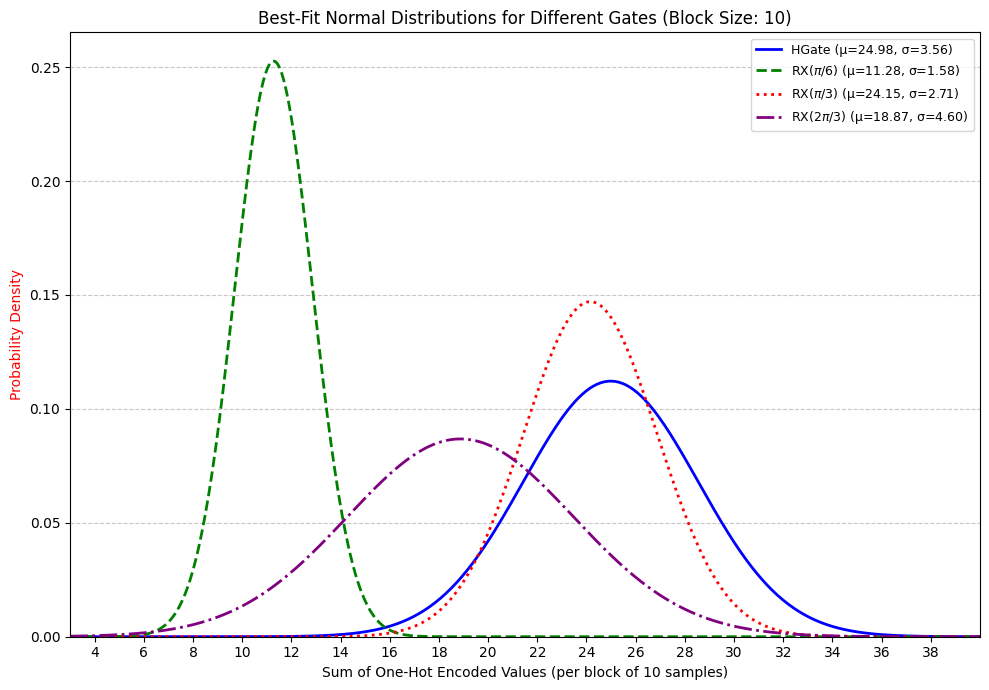

In [ ]:
from scipy.stats import norm
gate_biased = [HGate(), RXGate(np.pi/6), RXGate(np.pi/3), RXGate(2*np.pi/3)]
fixed_block_size = 10 # Fixed block size

data_to_plot_by_gate = {}

for gate in gate_biased:
    qc = galton_box_shifted(5, gate, draw=False) # Assuming 5 qubits
    backend = AerSimulator()
    compiled = transpile(qc, backend)
    job = backend.run(compiled, shots=100000, memory=True)
    memory_counts = job.result().get_memory()

    if isinstance(gate, HGate):
        gate_name_str = "HGate"
    elif isinstance(gate, RXGate):
        angle_val = gate.params[0]
        if angle_val == np.pi/6:
            gate_name_str = r"RX($\pi/6$)"
        elif angle_val == np.pi/3:
            gate_name_str = r"RX($\pi/3$)"
        elif angle_val == 2*np.pi/3:
            gate_name_str = r"RX($2\pi/3$)"
        else:
            gate_name_str = f"RX({angle_val:.2f})"
    else:
        gate_name_str = str(gate)

    print(f"Processing Gate: {gate_name_str}")

    _, block_sums, bin_size = post_process_histogram(memory_counts, fixed_block_size)
    mu, std = norm.fit(block_sums)
    data_to_plot_by_gate[gate_name_str] = {'mu': mu, 'std': std, 'block_sums': block_sums, 'bin_size': bin_size}
    print(f"  Gate {gate_name_str}: mean = {mu:.2f}, std = {std:.2f}")


fig, ax = plt.subplots(figsize=(10, 7))
ax2 = ax

all_block_sums = []
for gate_name_str in data_to_plot_by_gate:
    all_block_sums.extend(data_to_plot_by_gate[gate_name_str]['block_sums'])

if all_block_sums:
    min_overall_x = min(all_block_sums)
    max_overall_x = max(all_block_sums)
else:
    min_overall_x = 0
    max_overall_x = 10 

x_plot_range = np.linspace(min_overall_x - 1, max_overall_x + 1, 500) 
colors = ['blue', 'green', 'red', 'purple']
linestyles = ['-', '--', ':', '-.']

for i, gate_name_str in enumerate(data_to_plot_by_gate):
    data = data_to_plot_by_gate[gate_name_str]
    mu, std = data['mu'], data['std']
    
    p = norm.pdf(x_plot_range, mu, std)
    
    ax2.plot(x_plot_range, p, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)],
             linewidth=2, label=f'{gate_name_str} (μ={mu:.2f}, σ={std:.2f})')

ax.set_xlabel(f"Sum of One-Hot Encoded Values (per block of {fixed_block_size} samples)")
ax2.set_ylabel("Probability Density", color='red')
ax.set_title(f"Best-Fit Normal Distributions for Different Gates (Block Size: {fixed_block_size})")
ax2.set_ylim(bottom=0)
ax.set_xlim(min_overall_x - 1, max_overall_x + 1)
ax.set_xticks(range(int(min_overall_x), int(max_overall_x) + 1, max(1, fixed_block_size // 5)))

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(loc='upper right', fontsize=9) 

plt.tight_layout()
plt.show()

### Thus a quantum peg with bias can also give rise to normal distributions with varied characteristics. 

____
____

## Exponential distribution: Alternate 1

To generate an exponential-like distribution from a quantum Galton board, we need to modify the core "coin" operation. In a classical Galton board, the probability of a ball falling left or right is usually fixed at 0.5. To get a normal distribution, the probability remains constant at each level. For an exponential distribution, however, the probability of the particle moving in a certain direction must decay over time.

This can be achieved by constructing a quantum gate whose rotation angle is dependent on the row number, $r$, of the Galton board.

#### The Role of the $R_x$ Gate

The $R_x(\theta)$ rotation gate is used to control this probability. When applied to a qubit initialized to $|0\rangle$, it transforms the state to:

$$R_x(\theta)|0\rangle = \cos(\frac{\theta}{2})|0\rangle - i\sin(\frac{\theta}{2})|1\rangle$$

The probabilities of measuring $|0\rangle$ or $|1\rangle$ on this qubit are:

* $P(|0\rangle) = \cos^2(\frac{\theta}{2})$
* $P(|1\rangle) = \sin^2(\frac{\theta}{2})$

In our setup, an ancilla qubit acts as the "coin." We link the measurement of $|1\rangle$ on this coin qubit to the particle moving one step to the right (e.g., via a controlled-swap gate). Thus, the probability of moving right is $P_{right} = P(|1\rangle) = \sin^2(\frac{\theta}{2})$.


#### Constructing the Exponential Decay

For an exponential distribution, we need the probability of moving right to decrease as the number of steps ($r$) increases. We chose a row dependent probability function, 

$$P_{right}(r) \propto 0.5 + 0.1 r$$

where $r$ is the row number of the Galton board.

To connect this to our $R_x$ gate, we set:

$$\cos^2(\frac{\theta_r}{2}) =  min(1, P_{right}(r))$$


This $\theta_r$ is the angle we pass to the $R_x$ gate at each row $r$. The result is a circuit where the particle has a high probability of moving left at the beginning, but this probability decays with each subsequent step. The final distribution of the particle's position will therefore exhibit an exponential decay pattern.

#### Note that the exponential distribution can be observed only after a specific threshold for the size of the Galton board. This is because for smaller boards the number of possible states in the final superposition is low. 


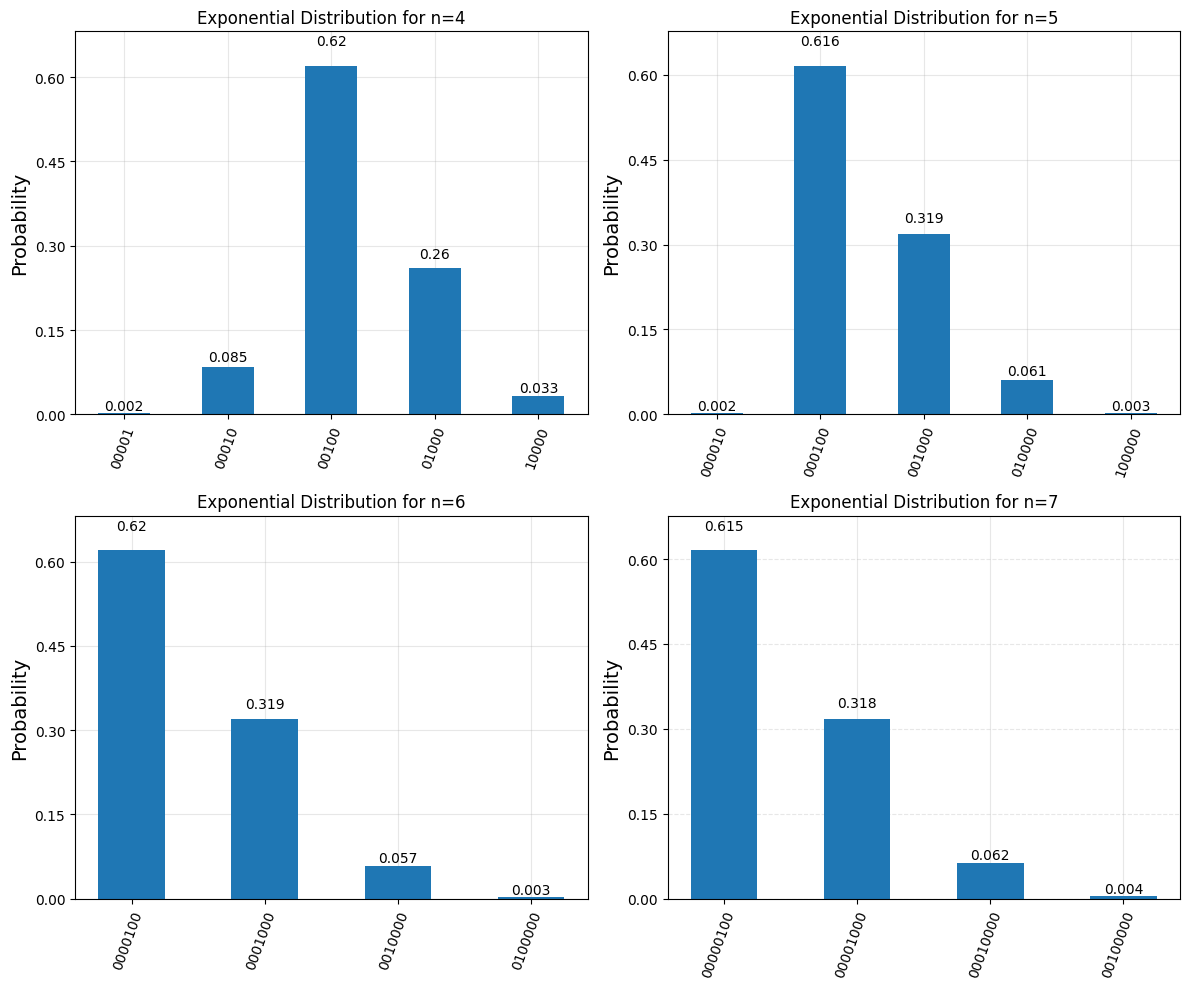

In [7]:
def row_dependent_gate_right(r):
    p = 0.5 + 0.1 * r  
    p = min(1.0, p)  # Ensure p is in the range [0, 1]
    theta = 2 * np.arccos(np.sqrt(p))
    return RXGate(theta)

gate_set = [row_dependent_gate_right]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 

n_values = [4, 5, 6, 7]

for i, n in enumerate(n_values):
    for gate in gate_set:
        qc = galton_box_shifted(n, gate)
        backend = AerSimulator()
        compiled_circuit = transpile(qc, backend, optimization_level=3)
        job = backend.run(compiled_circuit, shots=20000)
        counts = job.result().get_counts()
        total_shots = sum(counts.values())
        probabilities = {state: count/total_shots for state, count in counts.items()}
        
    
        plot_histogram(probabilities, ax=axes[i])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(f'Exponential Distribution for n={n}')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### We see that the exponential distribution is prominent beyond $n=5$ layers. Further one can appropriately tweak the $P_{right}(r)$ function to obtain different characteristics (like slope) for the exponential decay. 

### Fitting to an exponential distribution

Counts for n=6: {'0100000': 77, '0010000': 1221, '0001000': 6402, '0000100': 12300}
Counts for n=7: {'00100000': 63, '00000100': 12257, '00010000': 1260, '00001000': 6420}


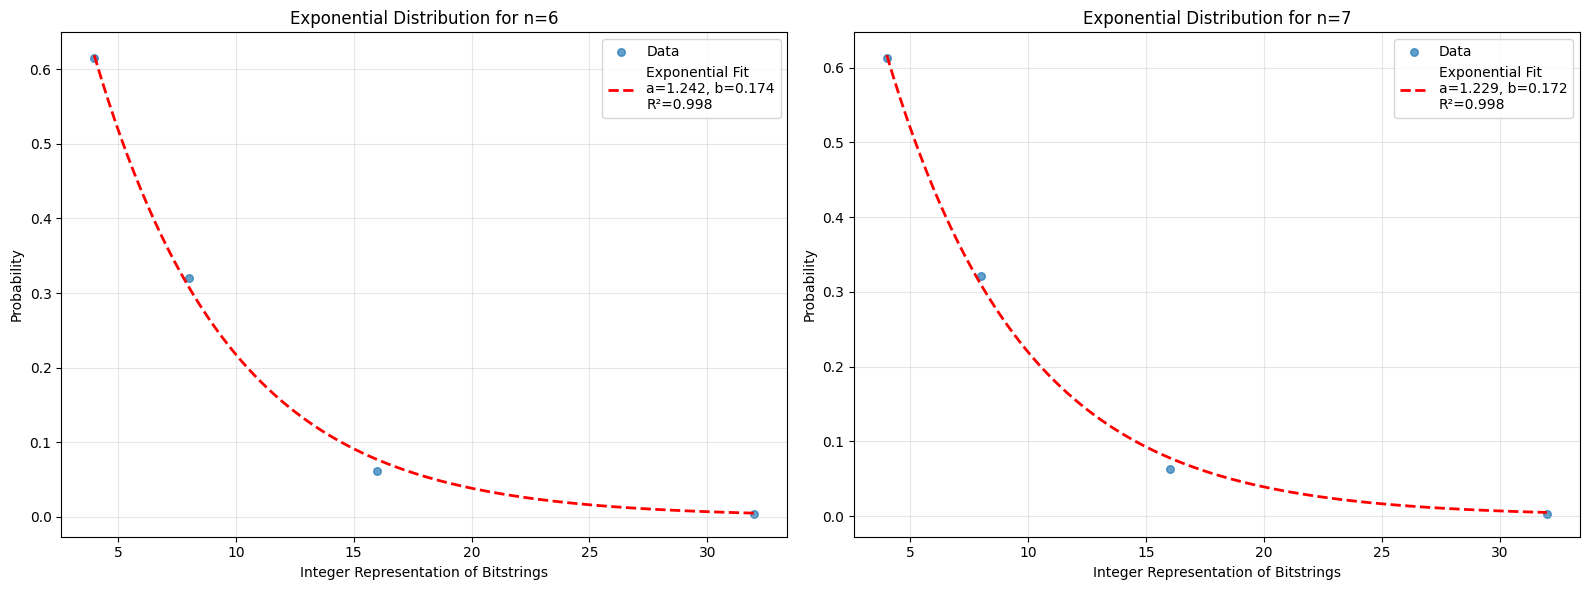

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

n_values = [6, 7]

def exponential_func(x, a, b):
    """Exponential decay function: a * exp(-b * x)"""
    return a * np.exp(-b * x)

def calculate_r_squared(y_actual, y_predicted):
    """Calculate R-squared value"""
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)

for i, n in enumerate(n_values):
    for gate in gate_set:
        qc = galton_box_shifted(n, gate)
        backend = AerSimulator()
        compiled_circuit = transpile(qc, backend, optimization_level=3)
        job = backend.run(compiled_circuit, shots=20000)
        counts = job.result().get_counts()
          
        total_shots = sum(counts.values())
        
        # Convert bitstrings to integers and get probabilities
        x_values = []
        y_values = []
        
        for bitstring, count in counts.items():
            # Convert bitstring to integer
            int_value = int(bitstring, 2)
            x_values.append(int_value)
            # Convert counts to probabilities
            y_values.append(count / total_shots)
        
        # Sort by x_values for proper plotting
        sorted_data = sorted(zip(x_values, y_values))
        x_values, y_values = zip(*sorted_data)
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        
        # Plot the data points
        axes[i].scatter(x_values, y_values, alpha=0.7, s=30, label='Data')
        
        # Fit exponential distribution
        try:
            # Initial guess for parameters 
            popt, pcov = curve_fit(exponential_func, x_values, y_values, 
                                 p0=[max(y_values), 0.1], maxfev=5000)
        
            x_smooth = np.linspace(min(x_values), max(x_values), 100)
            y_fit = exponential_func(x_smooth, *popt)
            
            # Calculate R-squared
            y_predicted = exponential_func(x_values, *popt)
            r_squared = calculate_r_squared(y_values, y_predicted)
            
            # Plot the fit
            axes[i].plot(x_smooth, y_fit, 'r--', linewidth=2, 
                        label=f'Exponential Fit\na={popt[0]:.3f}, b={popt[1]:.3f}\nR²={r_squared:.3f}')
            
        except Exception as e:
            print(f"Failed to fit exponential for n={n}: {e}")
            axes[i].text(0.5, 0.5, 'Fit failed', transform=axes[i].transAxes, 
                        ha='center', va='center')
        
        axes[i].set_xlabel('Integer Representation of Bitstrings')
        axes[i].set_ylabel('Probability')  
        axes[i].set_title(f'Exponential Distribution for n={n}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exponential distribution: Alternate 2

Unlike Alternate $1$, this involves several structural changes to the original Quantum Galton board. This approach is like a simple $1D$ quantum walk with exponentially decreasing rightward probability at each step $r$. Note that at every step the ball can move to the right or stay where it is. Thus this isn't a traditional Galton board but can be viewed as a Galton board where each level has only one "peg" and the decision is "move right" or "don't move". Once a particle decides not to move, it effectively gets absorbed at that position. 

#### Further explanation has been provided in the `galton_board_exponential_walk` function.

In [ ]:
def galton_board_exponential_walk(n: int, lambda_exp: float, *, draw=False) -> QuantumCircuit:
    """
    Quantum Galton board configured for an exponential-like distribution.
    
    This simulation models a particle that has a decreasing probability of moving to the right
    at each step, controlled by a rotation gate.

    Args:
        n (int): Number of steps in the walk.
        lambda_exp (float): The decay parameter for the exponential distribution.
        draw (bool): Whether to draw the circuit.
    
    Returns:
        QuantumCircuit: Configured circuit for the exponential walk.
    """
    # The number of data qubits is n+1 because the walk starts at position 0
    # and can go up to position n.
    data_q_size = n + 1
    
    # We need n+1 data qubits + 1 ancilla qubit for the coin
    q = QuantumRegister(data_q_size + 1, 'q')
    c = ClassicalRegister(data_q_size, 'c')
    qc = QuantumCircuit(q, c)
    
    # The ancilla qubit for the coin operation is the last qubit
    coin_q = q[data_q_size]
    
    # Initialize the particle at the starting position, index 0.
    # The particle is represented by a single qubit in the |1> state.
    qc.x(q[0])

    # The current position of the particle..
    particle_pos = 0

    # Perform the n steps of the exponential walk
    for r in range(n):
        # Calculate the rotation angle for the current step 'r', The angle is chosen to give a probability of moving right that
        # decays exponentially with the step number.
        prob_right = np.exp(-lambda_exp * r)
        if prob_right > 1:
            prob_right = 1
        
        angle = 2 * np.arcsin(np.sqrt(prob_right))
        
        # Apply the Ry coin to the ancilla qubit
        qc.ry(angle, coin_q)
        if particle_pos < n:
            qc.cswap(coin_q, q[particle_pos], q[particle_pos + 1])
            particle_pos += 1
            
        # Reset the coin qubit for the next step.
        qc.reset(coin_q)
        
    for i in range(data_q_size):
        qc.measure(q[i], c[i])

    if draw:
        qc.draw('mpl', style='clifford', fold=True)
        plt.show()

    return qc


Processing decay rate: 0.6
Processing decay rate: 0.8
Processing decay rate: 1


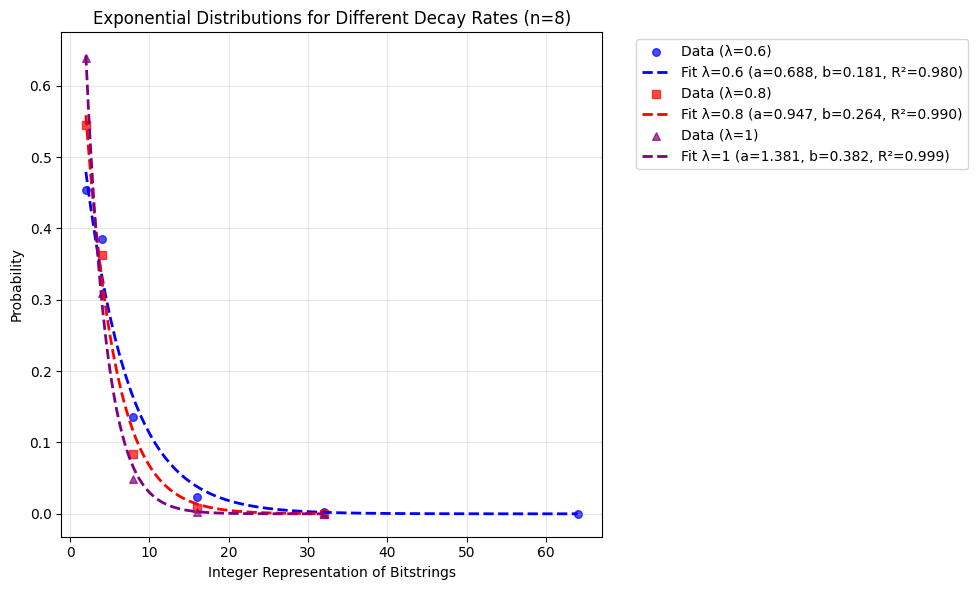

In [14]:
# Multiple decay rates to compare
n_steps = 8
decay_rates = [0.6, 0.8, 1]  # Different decay rates, keep above 0.5
colors = ['blue', 'red', 'purple']
markers = ['o', 's', '^']

fig, ax = plt.subplots(figsize=(10, 6))
backend = AerSimulator()

for i, decay_rate in enumerate(decay_rates):
    print(f"Processing decay rate: {decay_rate}")
    
    
    exponential_walk_circuit = galton_board_exponential_walk(n=n_steps, lambda_exp=decay_rate, draw=False)
    compiled = transpile(exponential_walk_circuit, backend)
    job = backend.run(compiled, shots=int(1e4))  
    counts = job.result().get_counts()
    
    total_shots = sum(counts.values())
    
    x_values = []
    y_values = []
    
    for bitstring, count in counts.items():
        int_value = int(bitstring, 2)
        x_values.append(int_value)
        y_values.append(count / total_shots)
    
    # Sort by x_values for proper plotting
    sorted_data = sorted(zip(x_values, y_values))
    x_values, y_values = zip(*sorted_data)
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    
    # Plot the data points
    ax.scatter(x_values, y_values, alpha=0.7, s=30, color=colors[i], 
               marker=markers[i], label=f'Data (λ={decay_rate})')
    
    # Fit exponential distribution
    try:
        popt, pcov = curve_fit(exponential_func, x_values, y_values, 
                              p0=[max(y_values), 0.1], maxfev=5000)
        
        x_smooth = np.linspace(min(x_values), max(x_values), 100)
        y_fit = exponential_func(x_smooth, *popt)
        
        y_predicted = exponential_func(x_values, *popt)
        r_squared = calculate_r_squared(y_values, y_predicted)
        
        # Plot the fit
        ax.plot(x_smooth, y_fit, '--', linewidth=2, color=colors[i],
                label=f'Fit λ={decay_rate} (a={popt[0]:.3f}, b={popt[1]:.3f}, R²={r_squared:.3f})')
                
    except Exception as e:
        print(f"Failed to fit exponential for decay rate {decay_rate}: {e}")

ax.set_xlabel('Integer Representation of Bitstrings')
ax.set_ylabel('Probability')
ax.set_title(f'Exponential Distributions for Different Decay Rates (n={n_steps})')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

___
___

## Hadamard quantum walk

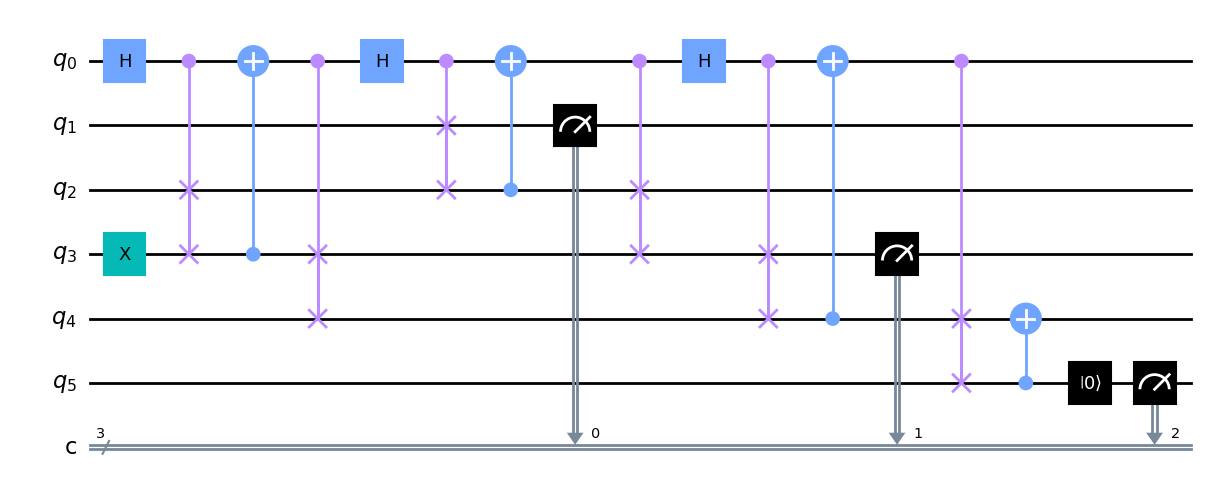

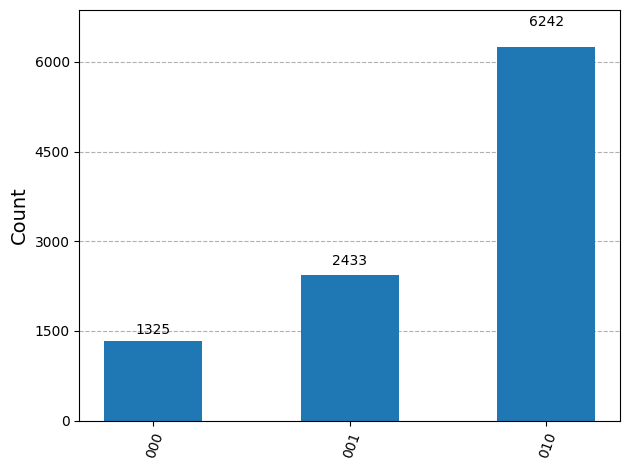

In [24]:
q = QuantumRegister(6, 'q')
c = ClassicalRegister(3, 'c')
qc = QuantumCircuit(q, c)

theta= np.pi/3 


qc.x(q[3])
qc.h(q[0])
qc.cswap(q[0], q[2], q[3])
qc.cx(q[3], q[0])
qc.cswap(q[0], q[3], q[4])

# qc.reset(q[0])
qc.h(q[0])
# qc.rx(theta, q[0])
qc.cswap(q[0], q[1], q[2])
qc.cx(q[2], q[0])
qc.cswap(q[0], q[2], q[3])
# qc.cx(q[3], q[0])
# qc.reset(q[0])
# qc.rx(theta, q[0])
qc.h(q[0])
qc.cswap(q[0], q[3], q[4])
qc.cx(q[4], q[0])
qc.cswap(q[0], q[4], q[5])

qc.cx(q[5], q[4])
qc.reset(q[5])

for i in range(0,3):
    qc.measure(q[2*i + 1], c[i])

qc.draw(output='mpl', style='clifford', fold=-1) 
plt.show()

backend = AerSimulator()
compiled = transpile(qc, backend)
job = backend.run(compiled, shots=1e4)
counts = job.result().get_counts()

plot_histogram(counts)
plt.show()


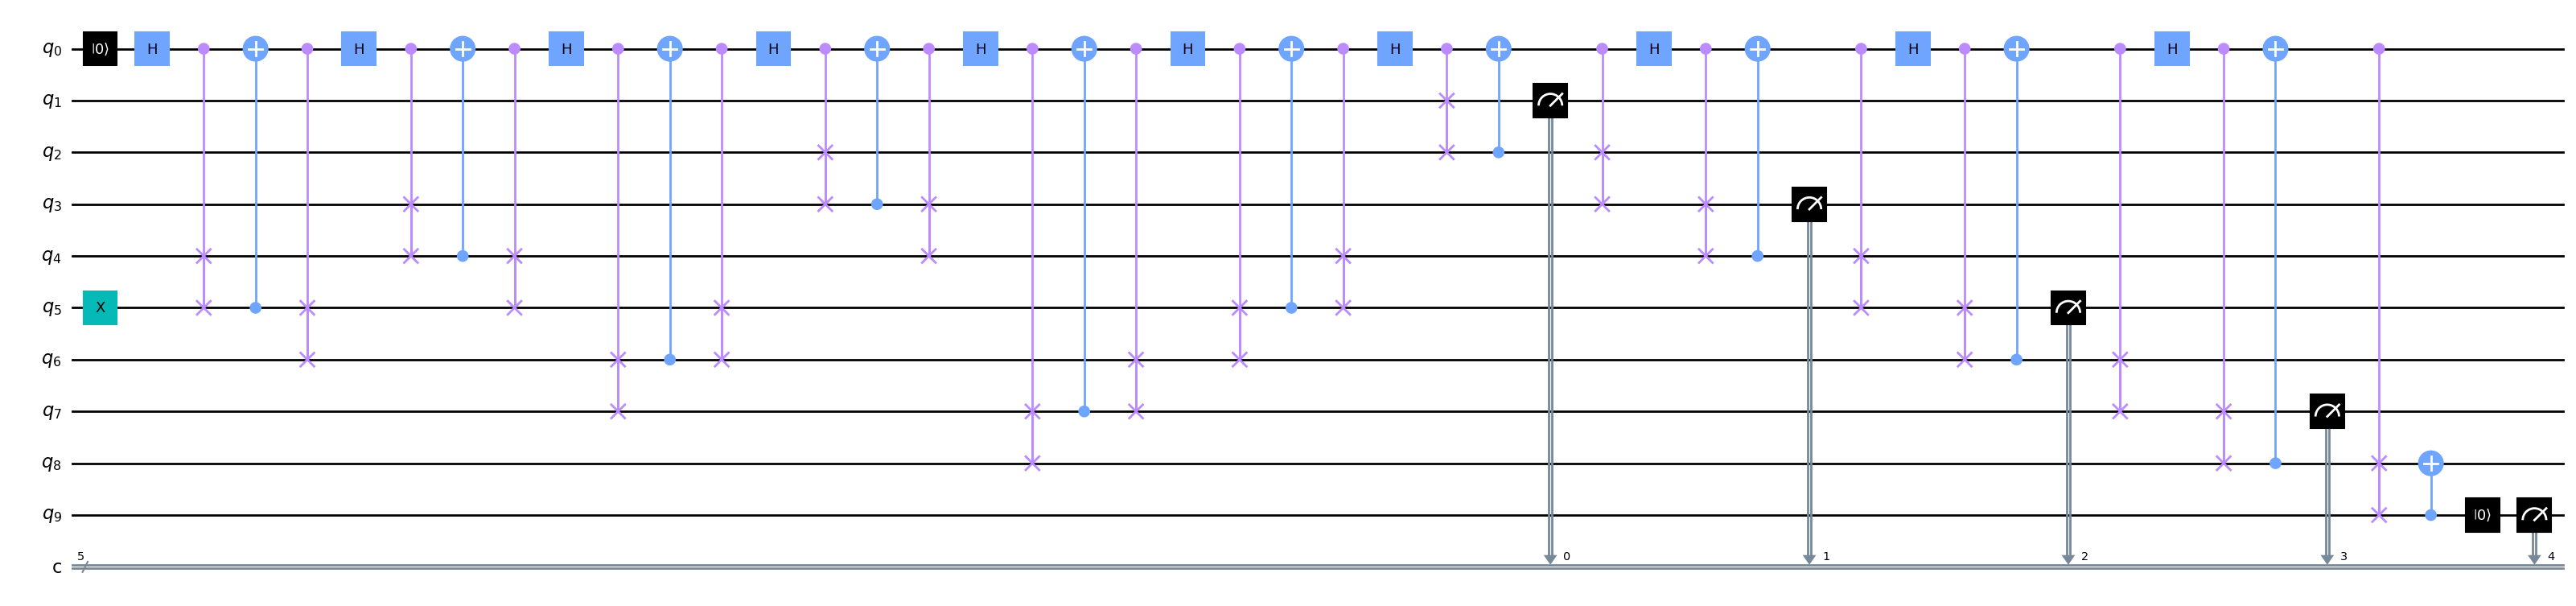

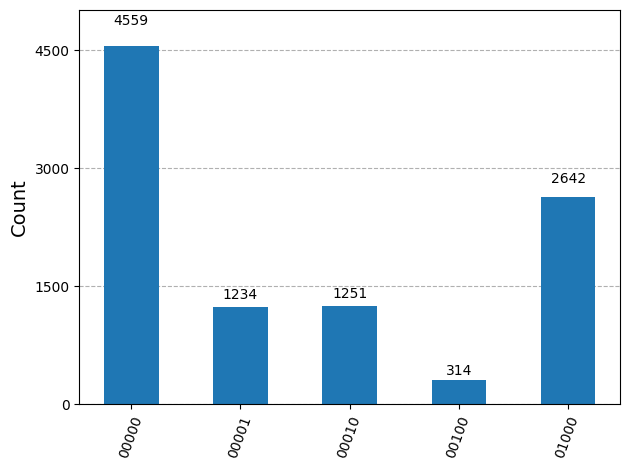

In [21]:
q = QuantumRegister(10, 'q')
c = ClassicalRegister(5, 'c')
qc = QuantumCircuit(q, c)

theta = 2*np.pi/3

qc.reset(q[0])
qc.x(q[5])
qc.h(q[0])
qc.cswap(q[0], q[4], q[5])
qc.cx(q[5], q[0])
qc.cswap(q[0], q[5], q[6])

# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[3], q[4])
qc.cx(q[4], q[0])
qc.cswap(q[0], q[4], q[5])
# qc.cx(q[5], q[0])
# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[6], q[7])
qc.cx(q[6], q[0])
qc.cswap(q[0], q[5], q[6])

# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[2], q[3])
qc.cx(q[3], q[0])
qc.cswap(q[0], q[3], q[4])
# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[7], q[8])
qc.cx(q[7], q[0])
qc.cswap(q[0], q[6], q[7])
# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0],q[5],q[6])
qc.cx(q[5],q[0])
qc.cswap(q[0],q[4],q[5])

# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[1], q[2])
qc.cx(q[2], q[0])
qc.cswap(q[0], q[2], q[3])
# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[3], q[4])
qc.cx(q[4], q[0])
qc.cswap(q[0], q[4], q[5])
# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[5], q[6])
qc.cx(q[6], q[0])
qc.cswap(q[0], q[6], q[7])
# qc.reset(q[0])
qc.h(q[0])
qc.cswap(q[0], q[7], q[8])
qc.cx(q[8], q[0])
qc.cswap(q[0], q[8], q[9])

qc.cx(q[9], q[8])
qc.reset(q[9])

for i in range(0, 5):
    qc.measure(q[2*i+1], c[i])

qc.draw(output='mpl', style='clifford', fold=-1)
plt.show()

backend = AerSimulator()
compiled = transpile(qc, backend)
job = backend.run(compiled, shots=1e4)
counts = job.result().get_counts()

plot_histogram(counts)
plt.show()

___
___

In [ ]:
# import classiq
# from classiq import *
# n=5

# @qfunc
# def galton_box_classiq(total_qubits: QArray[QBit]):
#     data_q = n + 1
#     centre = n + 1
#     right = 2*n + 1
#     anc = 0

#     # Initialize quantum circuit
#     X(total_qubits[centre])  # Initialize ball at center

#     # Process rows 1 to n-1 with custom coin gate
#     for r in range(1, n):
#         RESET(total_qubits[anc])  # Reset ancilla qubit

#         H(total_qubits[anc])  # Apply Hadamard gate as coin operation

#         # Get swap pairs for current row
#         pairs = _pair_sequence_shift_third(r, centre, right)

#         # Apply controlled-swap operations
#         for i, (a, b) in enumerate(pairs):
#             control(total_qubits[anc], lambda: SWAP(total_qubits[a], total_qubits[b]))  # Apply controlled-X gate
#             # Apply CX to next control
#             if i < len(pairs) - 1:
#                 next_a, _ = pairs[i + 1]
#                 cx_control = b if next_a > a else a
#                 control(total_qubits[cx_control], lambda: X(total_qubits[anc]))

#     # Process final row (n) with custom coin gate
#     RESET(total_qubits[anc])
    
#     H(total_qubits[anc])  # Apply Hadamard gate as coin operation for final row


#     # Final swap sequence
#     i = 0
#     while i <= 2*n -2:
#         control(total_qubits[anc], lambda: SWAP(total_qubits[i + 1], total_qubits[i + 2]))
#         control(total_qubits[i + 2], lambda: X(total_qubits[anc]))
#         control(total_qubits[anc], lambda: SWAP(total_qubits[i + 2], total_qubits[i + 3]))
#         if i + 4 < 2*n +1:
#             control(total_qubits[i + 3], lambda: X(total_qubits[anc]))
#         i += 2

# @qfunc
# def main(total_qubits: Output[QArray[QBit]]):
#     allocate(2 * n + 2, total_qubits)  # Allocate quantum bits for the Galton box
#     galton_box_classiq(total_qubits)

# preferences = Preferences(
#     timeout_seconds= 15000,
# )
# constraints= Constraints(
#       optimization_parameter=OptimizationParameter.WIDTH
#    )

# # Create and synthesize the quantum model
# qmod = create_model(main, preferences=preferences)    
# qmod = set_constraints(qmod, constraints)
# qprog = synthesize(qmod)
# circuit_width = qprog.data.width
# print(f"Circuit width: {circuit_width}")
# circuit_depth = qprog.transpiled_circuit.depth
# print(f"Circuit depth: {circuit_depth}")
# two_qubit_gates = qprog.transpiled_circuit.count_ops["cx"]
# print(f"Number of two-qubit gates: {two_qubit_gates}")
# total_gate_count = sum(qprog.transpiled_circuit.count_ops.values())
# print(f"Total gate count: {total_gate_count}")

# print("Gates after transpilation:")
# print(qprog.transpiled_circuit.count_ops)

# job = execute(qprog)
# results = job.result()[0].value 
# print(results.parsed_states)  # this will give the states